## Preprocessing

In [526]:
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

### Read Data

In [527]:
home_df = pd.read_csv('../data/raw/home_listings.csv')
condo_df = pd.read_csv('../data/raw/condo_listings.csv')

In [528]:
raw_listings = pd.concat([home_df, condo_df], axis=0, ignore_index=True)
listings_df = raw_listings.copy()

In [529]:
display(listings_df.head())
print("Number of listings: " + str(len(listings_df)))

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,municipal_eval,price
0,2 Storey,2 storey,1191.3,4076.29,3.0,1.0,2.0,Beauport,202012.0,2004.0,256000.0,332500.0
1,Bungalow,Open area,1261.0,9500.00,2.0,1.0,1.0,Deschambault,202112.0,1957.0,150500.0,265000.0
2,Townhouse,NaN,1645.0,1360.00,3.0,1.0,3.0,Mercier,202111.0,2006.0,479400.0,612000.0
3,Bi-generation,Link,2024.0,17000.00,4.0,3.0,1.0,Stoneham,202112.0,2019.0,NaN,526500.0
4,2 Storey,Waterfront,1469.0,16970.00,4.0,2.0,2.0,Trois-Rivières,202111.0,1925.0,NaN,NaN


Number of listings: 169894


### Subtype

In [530]:
listings_df['subtype'].value_counts(dropna=False)

Bungalow                        48502
2 Storey                        38477
Condominium                     28902
Semi-detached                   24858
Townhouse                       10140
Bi-generation                    8006
Split Level                      4158
1 1/2 Storey                     4046
Country Home                      659
Mobile home                       611
Acreage / Hobby Farm / Ranch      531
3 Storey                          363
Manufactured home                 184
Loft                              170
Bi-Level                          161
Villa                              63
Penthouse                          41
Misc.                              14
4 Storey                            8
Name: subtype, dtype: int64

Keep: Bungalow, 2 Storey, Condominium, Semi-detached, Townhouse, Bi-generation, Split Level, 1 1/2 Storey

In [531]:
subtypes = listings_df['subtype'].value_counts()
listings_df = listings_df[listings_df['subtype'].isin(subtypes.keys()[0:9])]

print("Number of listings: " + str(len(listings_df)))

Number of listings: 167748


### Style

In [532]:
listings_df['style'].value_counts(dropna=False).iloc[0:12]

NaN                     33608
2 storey                30921
Open area               25655
Detached                15325
Divided Co-Ownership    12145
Waterfront               5948
Link                     4333
Bungaloft                3948
New construction         3729
Side split               3334
Semi-detached            3298
Rural                    3039
Name: style, dtype: int64

Replace NaN styles with Unknown. Keep all other values.

In [533]:
listings_df['style'] = listings_df['style'].fillna('Unknown')

styles = listings_df['style'].value_counts()
listings_df = listings_df[listings_df['style'].isin(styles.keys())]

print("Number of listings: " + str(len(listings_df)))

Number of listings: 167748


### Living Area
Remove outliers

In [534]:
min_living_area = 500
max_living_area = 4000

In [535]:
listings_df = listings_df[listings_df['living_area'] >= min_living_area]
listings_df = listings_df[listings_df['living_area'] <= max_living_area]
listings_df['living_area'] = listings_df['living_area'].astype(int)

Replace NaN values with mean value.

In [536]:
mean_living_area = listings_df['living_area'].dropna().mean()
print("Mean Living Area: " + str(mean_living_area))

# Fill the NaN living areas with the mean value
listings_df['living_area'] = listings_df['living_area'].fillna(mean_living_area)

Mean Living Area: 1345.422774965148


Final Distribution

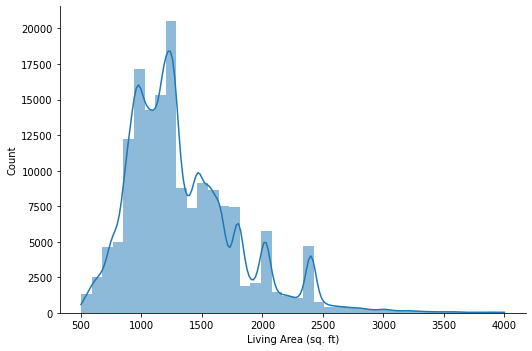

In [537]:
ax = sns.displot(listings_df, x='living_area', kde=True, fill=True, bins=40, height=5, aspect=1.5, linewidth=0)
ax.set(xlabel="Living Area (sq. ft)")
plt.savefig('./figures/preprocessing/living-area-hist.png', transparent=True)

In [538]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 163548


### Lot Dimensions

Replace Outliers & NaNs with mean.

In [539]:
min_lot_dimensions = 500
max_lot_dimensions = 50000

In [540]:
# Mean value without outliers
mean_lot_dimensions = listings_df[listings_df['lot_dimensions'] < max_lot_dimensions]['lot_dimensions'].dropna().mean()
print("Mean Lot Dimensions: " + str(mean_lot_dimensions))

Mean Lot Dimensions: 9084.889465803617


In [541]:
# Outliers
listings_df.loc[(listings_df['lot_dimensions'] > max_lot_dimensions), 'lot_dimensions'] = mean_lot_dimensions
# NaNs
listings_df['lot_dimensions'] = listings_df['lot_dimensions'].fillna(mean_lot_dimensions)
# Min Value
listings_df = listings_df[listings_df['lot_dimensions'] >= min_lot_dimensions]

In [542]:
listings_df['lot_dimensions'] = listings_df['lot_dimensions'].astype(int)

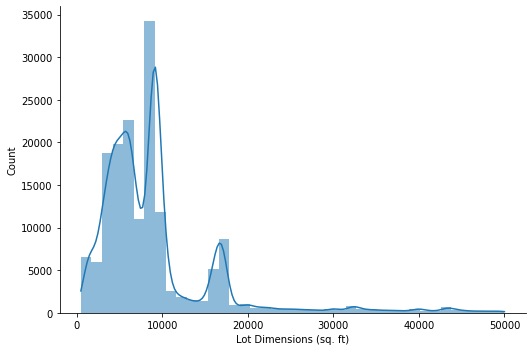

In [543]:
ax = sns.displot(listings_df, x='lot_dimensions', kde=True, fill=True, bins=40, height=5, aspect=1.5, linewidth=0)
ax.set(xlabel="Lot Dimensions (sq. ft)")
plt.savefig('./figures/preprocessing/lot-dimensions-hist.png', transparent=True)

In [544]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 162896


### Bedrooms, Bathrooms & Levels
No more than 5 bedrooms, 3 bathrooms and 3 stories.

In [545]:
listings_df = listings_df[listings_df['bedrooms'] <= 5]
listings_df = listings_df[listings_df['bathrooms'] <= 3]
listings_df = listings_df[listings_df['levels'] <= 3]

listings_df['bedrooms'] = listings_df['bedrooms'].astype(int)
listings_df['bathrooms'] = listings_df['bathrooms'].astype(int)
listings_df['levels'] = listings_df['levels'].astype(int)

In [546]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 155202


### Listing Date
Convert to datetime.

In [547]:
listings_df['listing_date'] = pd.to_datetime(listings_df['listing_date'], format='%Y%m')
print("Number of listings: " + str(len(listings_df)))
listings_df.head()

Number of listings: 155202


,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_date,year_of_construction,municipal_eval,price
0,2 Storey,2 storey,1191,4076,3,1,2,Beauport,2020-12-01,2004.0,256000.0,332500.0
1,Bungalow,Open area,1261,9500,2,1,1,Deschambault,2021-12-01,1957.0,150500.0,265000.0
2,Townhouse,Unknown,1645,1360,3,1,3,Mercier,2021-11-01,2006.0,479400.0,612000.0
3,Bi-generation,Link,2024,17000,4,3,1,Stoneham,2021-12-01,2019.0,NaN,526500.0
4,2 Storey,Waterfront,1469,16970,4,2,2,Trois-Rivières,2021-11-01,1925.0,NaN,NaN


### Year of Construction
Replace NaNs and outliers with mean value. Convert to int.

In [548]:
min_year_of_construction = 1850
max_year_of_construction = 2021

In [549]:
temp_listings_df = listings_df.copy()
temp_listings_df = temp_listings_df[temp_listings_df['year_of_construction'] >= min_year_of_construction]
temp_listings_df = temp_listings_df[temp_listings_df['year_of_construction'] <= max_year_of_construction]

mean_year_of_construction = temp_listings_df['year_of_construction'].dropna().mean()

print("Mean Year of Construction: " + str(int(mean_year_of_construction)))

Mean Year of Construction: 1990


In [550]:
listings_df['year_of_construction'] = listings_df['year_of_construction'].fillna(mean_year_of_construction)
listings_df.loc[(listings_df['year_of_construction'] <= min_year_of_construction), 'year_of_construction'] = mean_year_of_construction
listings_df.loc[(listings_df['year_of_construction'] >= max_year_of_construction), 'year_of_construction'] = mean_year_of_construction

listings_df['year_of_construction'] = listings_df['year_of_construction'].astype(int)

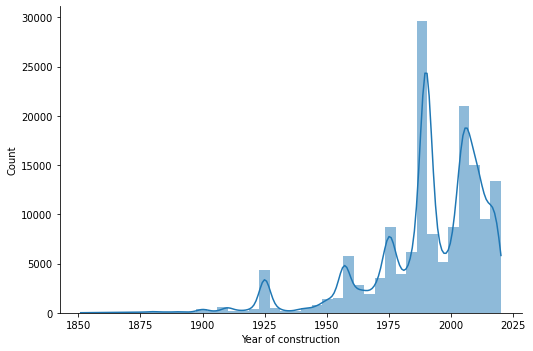

In [551]:
ax = sns.displot(listings_df, x='year_of_construction', kde=True, fill=True, bins=40, height=5, aspect=1.5, linewidth=0)
ax.set(xlabel="Year of construction")
plt.savefig('./figures/preprocessing/year_of_construction-hist.png', transparent=True)

In [552]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 155202


### Municipal Evaluation
Dropping this feature.

In [553]:
listings_df = listings_df.drop(['municipal_eval'], axis=1)

print("Number of listings: " + str(len(listings_df)))

Number of listings: 155202


### Price
Remove Outliers and NaNs

In [554]:
min_price = 20000
max_price = 1000000

In [555]:
listings_df = listings_df.dropna()
listings_df = listings_df[listings_df['price'] >= min_price]
listings_df = listings_df[listings_df['price'] <= max_price]

In [556]:
listings_df['price'] = listings_df['price'].astype(int)

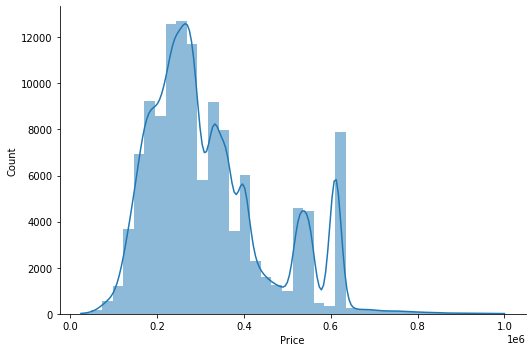

In [557]:
ax = sns.displot(listings_df, x='price', kde=True, fill=True, bins=40, height=5, aspect=1.5, linewidth=0)
ax.set(xlabel="Price")
plt.savefig('./figures/preprocessing/price-hist.png', transparent=True)

In [558]:
print("Number of listings: " + str(len(listings_df)))

Number of listings: 125242


### Location

Format Raw Location Strings

In [559]:
listings_df['location'] = listings_df['location'].str.replace('St-', 'Saint-')
listings_df['location'] = listings_df['location'].str.replace('Ste-', 'Sainte-')
listings_df['location'] = listings_df['location'].str.replace('Sts-', 'Saints-')
listings_df['location'] = listings_df['location'].str.replace('ND-', 'Notre-Dame-')
listings_df['location'] = listings_df['location'].str.replace('JC', 'Jacques-Cartier')

In [560]:
unknown_locations_dict = {
    "Saint-Denis-sur-Mer": "Saint-Denis",
    "Saint-Simon-De-Rimouski": "Saint-Simon",
    "Saint-Guillaume-D'Upton": "Saint-Guillaume",
    "Saint-Joseph-De-Ham-Sud": "Ham-Sud",
    "Saint-Adelphe-De-Champlain": "Saint-Adelphe",
    "Saint-Mathieu-De-Laprairie": "Saint-Mathieu",
    "Saint-Isidore-De-Laprairie": "Saint-Isidore",
    "Saint-Stanislas-De-Champlain": "Saint-Denis",
    "Saint-Sebastien-De-Frontenac": "Saint-Sebastien",
    "Sainte-Francoise-De-Lotbiniere": "Saint-Francoise",
    "Saint-Donat-De-Rimouski": "Rimouski",
    "Sheenboro": "Pontiac",
    "Mercier": "Hochelaga", 
    "Mont-Royal": "Ville de Mont-Royal",
    "Rosemont": "Rosemont-La Petite-Patrie",
    "Rivière des Prairies": "Rivière-des-Prairies-Pointe-aux-Trembles",
    "Pointe-Aux-Trembles": "Rivière-des-Prairies-Pointe-aux-Trembles",
    "Côte-des-Neiges": "Côte-des-Neiges–Notre-Dame-de-Grâce"
}

listings_df = listings_df.replace({'location': unknown_locations_dict})

Read Data

In [561]:
# Population Centers DataFrame
population_centers_df = pd.read_csv('../data/references/handmade/qc-population-centers.csv')
population_centers_df = population_centers_df[["Location", "RCM", "Region", "Display Name"]].set_index("Location")

# Mapper
with open('../data/processed/locations/location_mapper.pkl', 'rb') as f:
    location_mapper = pickle.load(f)

Replace locations using pre defined mapper.

In [562]:
listings_df = listings_df.replace({'location': location_mapper}).rename(columns={"location": "Location"}).set_index("Location")

Merge Dataframes

In [563]:
listings_df = pd.merge(listings_df, population_centers_df, left_index=True, right_index=True)

In [564]:
listings_df = listings_df.reset_index().drop(['Location'], axis=1).rename(columns={"Display Name": "Location"})

In [565]:
listings_df.sample(5)

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,listing_date,year_of_construction,price,RCM,Region,Location
34492,Bungalow,Detached,960,6157,3,2,1,2021-11-01,1990,400000,Laval,Laval,Fabreville
21057,Semi-detached,Unknown,881,5086,4,1,1,2021-12-01,2018,242500,Portneuf,Capitale-Nationale,Portneuf
107460,Semi-detached,2 storey,1560,3172,5,2,2,2021-12-01,2016,610000,La Côte-de-Beaupré,Capitale-Nationale,La Côte-de-Beaupré & L'Île-d'Orléans
64747,Bi-generation,Bungaloft,1267,10100,4,2,1,2021-12-01,1975,550000,Laval,Laval,Sainte-Dorothée & Laval-Ouest
64672,Bi-generation,Bungaloft,1267,10100,4,2,1,2021-12-01,1975,550000,Laval,Laval,Sainte-Dorothée & Laval-Ouest


### New Columns

Listing Year

In [566]:
listings_df.insert(8, 'listing_year', '')
listings_df['listing_year'] = pd.DatetimeIndex(listings_df['listing_date']).year
listings_df = listings_df[listings_df['listing_year'] <= 2021]

listings_df['listing_year'] = listings_df['listing_year'].astype(int)

Age

In [567]:
listings_df.insert(9, 'age', '')
listings_df['age'] = listings_df['listing_year'] - listings_df['year_of_construction']
listings_df = listings_df[listings_df['age'] >= 0]

listings_df['age'] = listings_df['age'].astype(int)

Yard Area

In [568]:
listings_df.insert(10, 'yard_area', '')
listings_df['yard_area'] = listings_df['lot_dimensions'] - listings_df['living_area']
listings_df['yard_area'] = listings_df['yard_area'].mask(listings_df['yard_area'].lt(0), 0)

listings_df['yard_area'] = listings_df['yard_area'].astype(int)

### Rearrange and Rename Columns

In [569]:
listings_df = listings_df[["subtype", "style", "living_area", "lot_dimensions", "bedrooms", "bathrooms",
                           "levels", "listing_date", "listing_year", "year_of_construction", "age", "Location", "RCM", "Region", "price"]]

In [570]:
listings_df = listings_df.rename(columns={"subtype": "Subtype", "style": "Style", "living_area": "Living Area", "lot_dimensions": "Lot Dimensions", "bedrooms": "Bedrooms",
                                 "bathrooms": "Bathrooms", "levels": "Levels", "listing_date": "Listing Date", "listing_year": "Listing Year", "year_of_construction": "Year of Construction", "age": "Age", "price": "Price"})


### Save Data

In [571]:
print("Original Data Length: " + str(len(raw_listings)))
print("Processed Data Length: " + str(len(listings_df)))

Original Data Length: 169894
Processed Data Length: 125144


In [572]:
listings_df.to_csv('../data/processed/processed_listings.csv', index=False)

In [573]:
listings_df.sample(20)

,Subtype,Style,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Date,Listing Year,Year of Construction,Age,Location,RCM,Region,Price
110779,Bungalow,Side split,892,5000,3,1,1,2019-08-01,2019,1996,23,Marguerite-D'Youville,Marguerite-D'Youville,Montérégie,215000
69351,Semi-detached,Open area,640,2962,2,1,1,2020-07-01,2020,2006,14,Les Rivières,Québec,Capitale-Nationale,230000
105287,Semi-detached,2 storey,1560,3172,5,2,2,2021-12-01,2021,2016,5,La Côte-de-Beaupré & L'Île-d'Orléans,La Côte-de-Beaupré,Capitale-Nationale,610000
31084,2 Storey,Unknown,1456,9200,3,1,2,2013-05-01,2013,1990,23,Drummond,Drummond,Centre-du-Québec,192000
6334,2 Storey,Waterfront,784,9084,3,1,2,2017-07-01,2017,2010,7,Charlevoix,Charlevoix,Capitale-Nationale,290000
60893,Bi-generation,Link,2024,17000,4,3,1,2021-12-01,2021,2019,2,La Jacques-Cartier,La Jacques-Cartier,Capitale-Nationale,526500
65137,Bi-generation,Bungaloft,1267,10100,4,2,1,2021-12-01,2021,1975,46,Sainte-Dorothée & Laval-Ouest,Laval,Laval,550000
93017,2 Storey,Canadian,2779,10591,4,1,2,2006-05-01,2006,1981,25,Saint-Bruno-de-Montarville,Longueuil,Montérégie,280000
55114,Condominium,Divided Co-Ownership,836,9084,2,1,1,2020-09-01,2020,1930,90,La Cité-Limoilou,Québec,Capitale-Nationale,215000
23801,Semi-detached,Unknown,881,5086,4,1,1,2021-12-01,2021,2018,3,Portneuf,Portneuf,Capitale-Nationale,242500
